<a href="https://colab.research.google.com/github/KarolChlasta/PJAIT-AdvancedML/blob/master/5.RNNAudio/heartbeat-sounds-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's in a heartbeat?

A PyTorch CNN to classify re-labeled set A. Inspired by work of Peter Grenholm (https://www.kaggle.com/toregil/what-s-in-a-heartbeat).

Dataset comes from Heartbeat Sounds Kaggle competition https://www.kaggle.com/kinguistics/heartbeat-sounds

This is set_a part of the dataset using labels by Peter Grenholm (https://www.kaggle.com/toregil/new-labels-for-set-a).

## Some medical background

Here are the links that will help you know what this challenge was all about.

* https://medictests.com/heart-tones/
* http://www.blaufuss.org/HStest/index.html (this flash file will help you visualise the S1, S2, S3, S4 and Murmur)
* https://en.wikipedia.org/wiki/Heart_sounds
* Heart Murmur : https://www.youtube.com/watch?v=V5kSBrSA-sA https://www.youtube.com/watch?v=1K0loRisIys https://www.youtube.com/watch?v=nievqLtaj7Y

More resources:
* https://depts.washington.edu/physdx/heart/demo.html
* https://www.easyauscultation.com/heart-sounds

The two *heart sounds* S1 / S2 (or lub / dub) are generated when the valves of the heart close. The first heart sound is generated by the closure of the inflow valves (mitralis and tricuspid) and marks the beginning of systole, when blood is pushed out to from the heart to the body and lungs. The second heart sound is generated by the closure of the outflow valves (aortic and pulmonary) and marks the beginning of diastole, the slightly longer phase when the heart is refilled.

A heart *murmur* is a low-frequency sound created by turbulent flow over the valves. Especially during systole, it can be a normal finding, created by the high speed flow in aorta. A murmur can also be a sign of malfunction of the valves, such as *stenosis*, when the valve is too narrow and tight, or *insufficiency*, when there is leakage over a valve that fails to close.

A *third or forth heart sound* is thought to be due to abnormal blood flow in the ventricles and is a sign of advanced heart disease. They have been described from the beginning of days, from the time when the stethoscope wasn't invented and doctors listened with ear-to-chest. 

My experience from med school is that extra heart sounds don't really exist any more - at least not outside of cardiac surgery. When a faint extra sound was found on the wards, it was mandatory for everyone to go there and listen, and sometimes the sound we heard was imagined rather than real. Even being more generous than that, most would agree that extra heart sounds are rarer and less important than murmurs by an order of magnitude. I have certainly never based any clinical decision on their presence or not.

## Installation of older libraries for fast.ai v0.7

In [1]:
!pip install torchvision fastai==0.6

     |████████████████████████████████| 430kB 4.8MB/s 
     |████████████████████████████████| 2.7MB 21.2MB/s 
     |████████████████████████████████| 1.5MB 39.3MB/s 
     |████████████████████████████████| 20.9MB 150kB/s 
     |████████████████████████████████| 5.9MB 58.3MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 870kB 54.3MB/s 
     |████████████████████████████████| 481kB 52.9MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 112kB 67.1MB/s 
     |████████████████████████████████| 112kB 73.6MB/s 
  Created wheel for fastai: filename=fastai-0.6-cp36-none-any.whl size=69788 sha256=167cd993466057590d55ea244bbc910872ecdac80e647812bdeee5b481bf3969
  Stored in directory: /root/.cache/pip/wheels/98/2b/88/fe4cfe5bfa9cfea91cdfd2fe205f88746bf103f7b2994dffba
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl si

In [2]:
!pip install torch torchvision fastai==0.7.0

## Installation of PyDrive wrapper & import of libraries

In [0]:
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pathlib import Path
import os

def download_and_save(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  # fetch file
  downloaded.FetchContent()
  # write file
  with open(file_name,'wb') as f:
       f.write(downloaded.content.read())
      
  print(f'Saved {file_name}')
  
FILE_NAME, FILE_ID = ['file_name', 'file_id']

## Data download

In [12]:
from pathlib import Path

dataset_path = Path('/content/data/heartbeat-sounds/'); dataset_path
!mkdir -p $dataset_path
!ls -la $dataset_path/

total 8
drwxr-xr-x 2 root root 4096 Dec 27 01:06 .
drwxr-xr-x 3 root root 4096 Dec 27 01:06 ..


## Downloading heartbeat-sounds5 dataset

In [13]:
# heartbeat-sounds5.tgz, https://drive.google.com/open?id=1OWytJLNOCkRxNHyMQFzqRje1HG7pvj7B
heartbeat_sounds = {FILE_NAME: 'heartbeat-sounds5.tgz', FILE_ID: '1OWytJLNOCkRxNHyMQFzqRje1HG7pvj7B'}
heartbeat_sounds_path = dataset_path / heartbeat_sounds[FILE_NAME]

download_and_save(heartbeat_sounds_path, heartbeat_sounds[FILE_ID])

Saved /content/data/heartbeat-sounds/heartbeat-sounds5.tgz


In [0]:
# unpack

!tar -xf $heartbeat_sounds_path -C $dataset_path

In [15]:
# SetB.zip, https://drive.google.com/open?id=1PZqOta9zA-7Y0tf7y9ZEV1OlxTMUvhkm
setb = {FILE_NAME: 'SetB.zip', FILE_ID: '1PZqOta9zA-7Y0tf7y9ZEV1OlxTMUvhkm'}
setb_path = dataset_path / setb[FILE_NAME]
download_and_save(setb_path, setb[FILE_ID])

Saved /content/data/heartbeat-sounds/SetB.zip


In [0]:
!mkdir /content/data/heartbeat-sounds/setb/

In [0]:
!unzip -q -o $setb_path -d /content/data/heartbeat-sounds/setb/

In [18]:
ls -lah $dataset_path

total 105M
drwxr-xr-x 4 root root  4.0K Dec 27 01:06 ./
drwxr-xr-x 3 root root  4.0K Dec 27 01:06 ../
drwxr-xr-x 5  501 staff 4.0K Oct 13  2018 heartbeat-sounds5/
-rw-r--r-- 1 root root   82M Dec 27 01:06 heartbeat-sounds5.tgz
drwxr-xr-x 7 root root  4.0K Dec 27 01:06 setb/
-rw-r--r-- 1 root root   24M Dec 27 01:06 SetB.zip


## Downloading sample data

In [19]:
# custom_samples.tgz, https://drive.google.com/open?id=1qcanWbaLi2pHA7dJzobwlyVGCRGtzrSt
custom_samples = {FILE_NAME: 'custom_samples.tgz', FILE_ID: '1qcanWbaLi2pHA7dJzobwlyVGCRGtzrSt'}
custom_samples_path = dataset_path / custom_samples[FILE_NAME]
download_and_save(custom_samples_path, custom_samples[FILE_ID])

Saved /content/data/heartbeat-sounds/custom_samples.tgz


In [0]:
!tar -xf $custom_samples_path -C $dataset_path

In [21]:
ls -lah $dataset_path

total 115M
drwxr-xr-x 5 root root  4.0K Dec 27 01:06 ./
drwxr-xr-x 3 root root  4.0K Dec 27 01:06 ../
drwxr-xr-x 2  501 staff 4.0K Aug 31  2018 custom_samples/
-rw-r--r-- 1 root root   11M Dec 27 01:06 custom_samples.tgz
drwxr-xr-x 5  501 staff 4.0K Oct 13  2018 heartbeat-sounds5/
-rw-r--r-- 1 root root   82M Dec 27 01:06 heartbeat-sounds5.tgz
drwxr-xr-x 7 root root  4.0K Dec 27 01:06 setb/
-rw-r--r-- 1 root root   24M Dec 27 01:06 SetB.zip


# Loading libraries

##Library configuration

In [0]:
from pathlib import Path
from collections import Counter
import wave
import struct
from pathlib import Path

import numpy as np
import pandas as pd
from pprint import pprint

from scipy.io import wavfile
from scipy.signal import decimate
from scipy import signal
from scipy import fft, arange

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import *

import torch
import torch.nn as nn

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from fastai.io import *
from fastai.conv_learner import *
from fastai.column_data import *

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from functools import reduce    

In [0]:
USE_CUDA = True

In [0]:
%matplotlib inline

## Loading and Manipulating Heartbeat Audio

This part of notebook will show you how to load and manipulate audio data in Python. 

The Heartbeat Sounds dataset is primarily audio-based: all of the heartbeat sounds are stored as WAV files that record either normal or abnormal heartbeats. So let's learn how to load and play with WAVs in Python.

In general, uncompressed audio is stored as a sequence of numbers that indicate the amplitude of the recorded sound pressure at each time point. In the WAV standard, these numbers are packed into a bytestring. The interpretation of this byestring depends primarily on two factors: first, the sampling rate, usually given in Hertz, which indicates how many number samples comprise a second's worth of data; and second, the bit depth (or sample width), which indicates how many bits comprise a single number.

These parameters, along with other parameters like the number of channels (e.g., is the audio mono or stereo) are stored in the header of the WAV file.

The `wave` library handles the parsing of WAV file headers, which include the parameters mentioned above. Let's load the `wave` library and use it to open a sound file.

In [25]:
FNAME = 'data/heartbeat-sounds/heartbeat-sounds5/normal/normal__201101070538.wav'

f = wave.open(FNAME)

# frames will hold the bytestring representing all the audio frames
frames = f.readframes(-1)
print(frames[:20])

b'\x0e\x00\x11\x00\x0e\x00\x00\x00\x02\x00\x0b\x00\xfe\xff\x05\x00\x05\x00\x04\x00'


So `frames` now holds the entire bytestring representing all the audio samples in the sound file. We need to unpack this bytestring into an array of numbers that we can actually work with.

The first question is: how many bytes represent a single observation? In my experience in voice recording, 16-bit and 24-bit are the most common sample widths, but you can find a whole collection [on Wikipedia](https://en.wikipedia.org/wiki/Audio_bit_depth).

Powers of 2 tend to be the easiest to work with, and luckily for us the heartbeat audio seems to be 16-bit. We can check this by using the getsamplewidth() method on the wave file:

In [26]:
print(f.getsampwidth())

2


The result of getsamplewidth() is in bytes, so multiply it by 8 to get the bit depth. Since the result from the call is 2, that means we're looking at a 16-bit file.

We'll unpack the bytestring by using the `struct` library in Python. `struct` requires a format string based on C format characters, which you can take a look at [on the documentation page for Python's struct library](https://docs.python.org/2/library/struct.html).

We're in luck with the 16-bit depth, since the `struct` library prefers powers of 2. 16 bits corresponds to 2 bytes, so we'll use the signed format that corresponds to 2 bytes; according to [the C format characters](https://docs.python.org/2/library/struct.html#format-characters), we should use the format character 'h'.

A slight trick in the `struct` library is that it wants its format string to exactly match the expected size, so we have to multiply the format character 'h' by the number of frames in the bytestring:

In [27]:
samples = struct.unpack('h'*f.getnframes(), frames)
print(samples[:10])

(14, 17, 14, 0, 2, 11, -2, 5, 5, 4)


To get the timing, we'll grab the sampling rate from the wave object.

In [28]:
framerate = f.getframerate()
t = [float(i)/framerate for i in range(len(samples))]
print(t[:10])

[0.0, 2.2675736961451248e-05, 4.5351473922902495e-05, 6.802721088435374e-05, 9.070294784580499e-05, 0.00011337868480725624, 0.00013605442176870748, 0.00015873015873015873, 0.00018140589569160998, 0.00020408163265306123]


In [29]:
framerate

44100

Now we can take a look at the waveform.

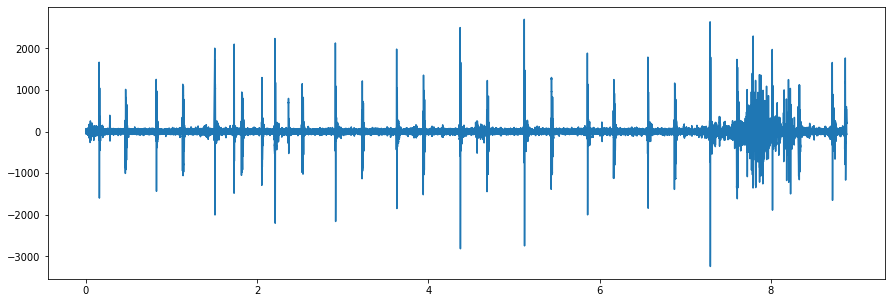

In [30]:
plt.figure(figsize=(15,5))
plt.plot(t, samples);

# Pre-processing the data

We're loading wav samples from dataset category folders. For now, we will also make all time series have equal length. We truncate longest time series to fit first layer of the CNN and make shortest longer by repeating samples.

In [0]:
# for simplified dataset set_a
INPUT_LIB = Path('data/heartbeat-sounds/heartbeat-sounds5/')
SAMPLE_RATE = 44100
CLASSES = ['artifact', 'normal', 'murmur']
MIN_DURATION = None
DOWNSAMPLING_FACTORS=[8,8,4]
EXPECTED_LENGTH = 1551*8*8*4

In [0]:
CLASS2IDX = {x:i for i,x in enumerate(CLASSES)}

In [0]:
def scan_dataset_folders(dataset_path):
    class_paths = sorted([x for x in list(INPUT_LIB.iterdir()) if x.name[0] != '.'])
    x_filenames = []
    y_classes = []
    for class_path in class_paths:
        samples_fn = sorted(list(class_path.iterdir()))
        print(class_path.name, len(samples_fn))
        for sample_fn in samples_fn:
            x_filenames.append(sample_fn)
            y_classes.append(class_path.name)
    return x_filenames, y_classes

def load_wav_file(path):
    framerate, samples = wavfile.read(str(path))
    assert framerate == SAMPLE_RATE
    duration = len(samples)/framerate
    return samples, framerate, duration

def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def downsample(samples, framerate, dfs=[8,8,4]):
    '''dfs - downsampling factors'''
    # TODO: make it work for multiple samples
    s=np.array(samples)    
    s=s[np.newaxis,:]

    for df in dfs:
        s = signal.decimate(s, df, axis=1, zero_phase=True)
    s = s[0,:]
    
    #Scale each observation to unit variance, it should already have mean close to zero.
    s = s / np.std(s)

    return s

def downsampled_framerate(framerate, dfs=[8,8,4]):
    product = reduce((lambda x, y: x * y), dfs)
    framerate2=framerate/product
    return framerate2

def times_array(s, framerate2):
    t2 = [float(i)/framerate2 for i in range(len(s))]
    return t2

In [0]:
class DatasetSample:
    # source data
    fn_path = None
    framerate = None 
    samples = None 
    duration = None
    y_class = None
    
    # processed data
    # samples_repeated = None
    samples_9s = None
    samples_downsampled = None
    downsampled_framerate = None
    y = None
    
    def __repr__(self):
            """"""
            return "<DatasetSample: %s>" % self.__dict__
    
    def __init__(self, fn_path, framerate, samples, duration, y_class = None):
        self.fn_path = fn_path
        self.framerate = framerate
        self.samples = samples
        self.duration = duration
        self.y_class = y_class

In [0]:
def dataset_sample_from_file(fn_path):
    samples, framerate, duration = load_wav_file(fn_path)
    ds_sample = DatasetSample(fn_path, framerate, samples, duration)    
    return ds_sample

def load_all_dataset_samples(PATH, min_duration=None):
    x_filenames, y_classes = scan_dataset_folders(PATH)    
    all_ds_samples = [dataset_sample_from_file(fn_path) for fn_path in x_filenames]
    
    for ds_sample, y_class in zip(all_ds_samples, y_classes):
        ds_sample.y_class = y_class
    
    if min_duration is not None:
        ds_samples = [ds for ds in all_ds_samples if ds.duration>=min_duration]
    else:
        ds_samples = all_ds_samples
    
    return ds_samples

def process_dataset_sample(ds_sample, expected_length, downsampling_factors):
    ds_sample.samples_9s = ds_sample.samples[:expected_length]
    ds_sample.duration = len(ds_sample.samples_9s)/ds_sample.framerate
    samples_repeated = repeat_to_length(ds_sample.samples_9s, expected_length)
    samples_downsampled = downsample(samples_repeated, ds_sample.framerate, downsampling_factors)    
    ds_sample.samples_downsampled = samples_downsampled
    ds_sample.framerate_downsampled = downsampled_framerate(ds_sample.framerate, downsampling_factors)    
    ds_sample.y = CLASS2IDX[ds_sample.y_class] if ds_sample.y_class is not None else None
    return ds_sample

def process_dataset_samples(ds_samples, expected_length, downsampling_factors):
    for ds in tqdm(ds_samples):
        ds = process_dataset_sample(ds, expected_length, downsampling_factors)
    return ds_samples

In [36]:
ds_samples = load_all_dataset_samples(INPUT_LIB, MIN_DURATION)
ds_samples = process_dataset_samples(ds_samples, EXPECTED_LENGTH, DOWNSAMPLING_FACTORS)

artifact 58
murmur 53
normal 65
100%|██████████| 176/176 [00:02<00:00, 69.05it/s]


## Convert data to numpy arrays
Let's make a training and testing sets from the files. We will collect all the time series in 2D numpy arrays, that can be used for neural network training.

In [0]:
ds_samples_train, ds_samples_test = train_test_split(ds_samples, test_size=0.25)

In [0]:
x_train = np.stack([s.samples_downsampled for s in ds_samples_train])
x_test = np.stack([s.samples_downsampled for s in ds_samples_test])

In [0]:
y_train = [s.y for s in ds_samples_train]
y_test = [s.y for s in ds_samples_test]

Now, as explained in another [notebook][1], I will not use the classification from new_info['target'] but instead my own labels, with three classes 0=artifact, 1=normal/extrahls, and 2=murmur.


  [1]: https://www.kaggle.com/toregil/d/kinguistics/heartbeat-sounds/misclassified-files-in-set-a/editnb "notebook"

We now downsample the data with what is in effect a very aggressive low pass filter. This is not needed for computational time, but it seems to improve generalization on this dataset. With more data, we should remove or reduce this step and instead add 2-5 extra convolution layers. The reason this works is probably that what you hear in the stethoscope is almost exclusively low frequency sounds, especially murmurs.

# Training on spectrogram images

## Plot helpers

In [0]:
def plotSpectrogram(s, framerate2):
    """
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    """    
    f, t, Sxx = signal.spectrogram(s, framerate2, nperseg=64, noverlap=32)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

def plotSpectrum(y,Fs):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    https://glowingpython.blogspot.com/2011/08/how-to-plot-frequency-spectrum-with.html
    """
    n = len(y) # length of the signal
    k = arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]

    plt.plot(frq,abs(Y),'r') # plotting the spectrum
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')

def plotWaveform(s, t2):
    plt.plot(t2, s)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

def plotWaveformSpectrogramAndSpectrum(s, framerate2, t2):
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1)
    plotWaveform(s, t2)
    plt.subplot(3,1,2)
    plotSpectrogram(s, framerate2)
    plt.subplot(3,1,3)
    plotSpectrum(s, framerate2)
    plt.show()

## Plot one sample

In [0]:
ds_sample = ds_samples[0]

In [42]:
ds_sample.y_class

'artifact'

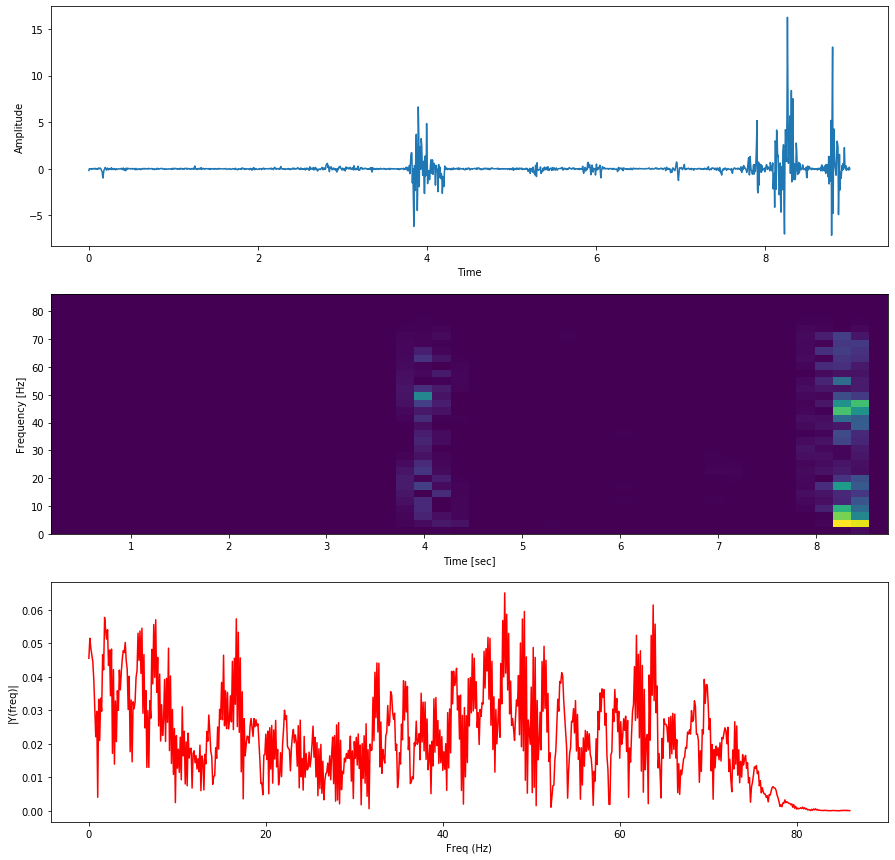

In [43]:
t2 = times_array(ds_sample.samples_downsampled, ds_sample.framerate_downsampled)
plotWaveformSpectrogramAndSpectrum(ds_sample.samples_downsampled, ds_sample.framerate_downsampled, t2)

## Format and save one spectrogram

In [0]:
def make_image(samples, framerate, outputname, size=(1, 1), dpi=80):
    # https://stackoverflow.com/questions/8218608/scipy-savefig-without-frames-axes-only-content/8218887#8218887
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('gnuplot2')

    f, t, Sxx = signal.spectrogram(samples, framerate, nperseg=64, noverlap=32)
    ax.pcolormesh(t, f, Sxx)

    plt.savefig(outputname, dpi=dpi)

In [0]:
Path('./output/').mkdir(parents=True, exist_ok=True)

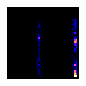

In [46]:
fname = Path('./output/output.png')
make_image(ds_sample.samples_downsampled, ds_sample.framerate_downsampled, fname, dpi=224)

## Save spectrogram dataset

In [0]:
!rm -rf ./output_split/
# bez tego blagam w plikach

In [0]:
output_path = Path('./output_split')

In [0]:
def save_dataset(ds_samples, output_path):
    for ds_sample in ds_samples[:]:
        class_path: Path = output_path / ds_sample.y_class
        class_path.mkdir(parents=True, exist_ok=True)
        output_img_path = class_path / ds_sample.fn_path.with_suffix('.png').name
        # print(ds_sample.fn_path.name, ds_sample.y_class)
        print(output_img_path)
        make_image(ds_sample.samples_downsampled, ds_sample.framerate_downsampled, output_img_path, dpi=224)
        plt.show()

output_split/train/normal/Aunlabelledtest__201103011036.png


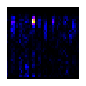

output_split/train/artifact/artifact__201106141701.png


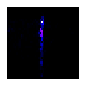

output_split/train/murmur/murmur__201108222232.png


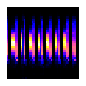

output_split/train/artifact/artifact__201106211041.png


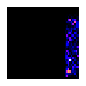

output_split/train/murmur/murmur__201108222231.png


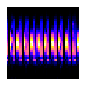

output_split/train/artifact/artifact__201106040933.png


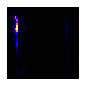

output_split/train/murmur/extrahls__201104021355.png


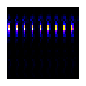

output_split/train/murmur/normal__201108011115.png


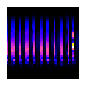

output_split/train/murmur/Aunlabelledtest__201108222228.png


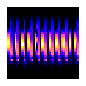

output_split/train/murmur/Aunlabelledtest__201108011111.png


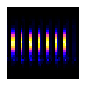

output_split/train/artifact/Aunlabelledtest__201106212102.png


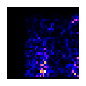

output_split/train/artifact/artifact__201106211430.png


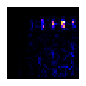

output_split/train/murmur/Aunlabelledtest__201105031730.png


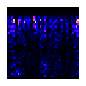

output_split/train/normal/Aunlabelledtest__201103241336.png


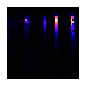

output_split/train/murmur/murmur__201101051104.png


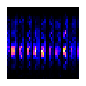

output_split/train/normal/normal__201108011114.png


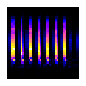

output_split/train/artifact/artifact__201106161019.png


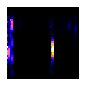

output_split/train/artifact/artifact__201106010602.png


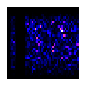

output_split/train/murmur/murmur__201106141148.png


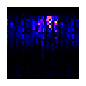

output_split/train/normal/extrahls__201103150114.png


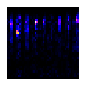

output_split/train/normal/normal__201106210943.png


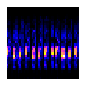

output_split/train/artifact/Aunlabelledtest__201103232251.png


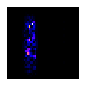

output_split/train/normal/extrahls__201104140118.png


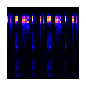

output_split/train/normal/normal__201103140822.png


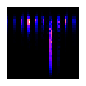

output_split/train/normal/Aunlabelledtest__201104012144.png


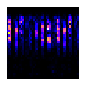

output_split/train/artifact/Aunlabelledtest__201102200848.png


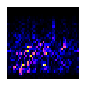

output_split/train/artifact/artifact__201105040918.png


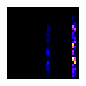

output_split/train/artifact/Aunlabelledtest__201106170857.png


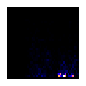

output_split/train/normal/normal__201102260502.png


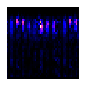

output_split/train/artifact/artifact__201106221254.png


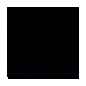

output_split/train/murmur/murmur__201108222233.png


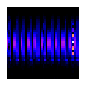

output_split/train/artifact/Aunlabelledtest__201106010807.png


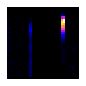

output_split/train/normal/normal__201102270940.png


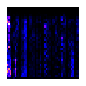

output_split/train/murmur/Aunlabelledtest__201108011117.png


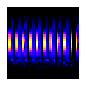

output_split/train/normal/Aunlabelledtest__201101091156.png


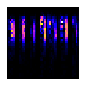

output_split/train/murmur/murmur__201108222227.png


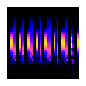

output_split/train/artifact/artifact__201106212112.png


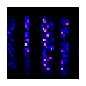

output_split/train/normal/extrahls__201101160804.png


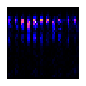

output_split/train/normal/normal__201108011112.png


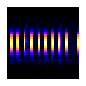

output_split/train/murmur/Aunlabelledtest__201108222225.png


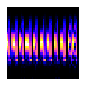

output_split/train/artifact/Aunlabelledtest__201106031556.png


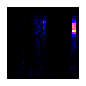

output_split/train/murmur/Aunlabelledtest__201101051105.png


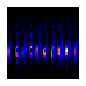

output_split/train/murmur/murmur__201108222224.png


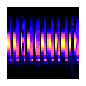

output_split/train/artifact/artifact__201106050353.png


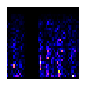

output_split/train/normal/normal__201101070538.png


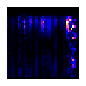

output_split/train/artifact/Aunlabelledtest__201106130440.png


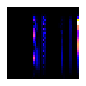

output_split/train/artifact/Aunlabelledtest__201102081033.png


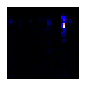

output_split/train/murmur/Aunlabelledtest__201108222222.png


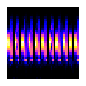

output_split/train/normal/normal__201106111136.png


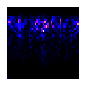

output_split/train/artifact/artifact__201106101314.png


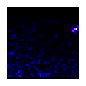

output_split/train/murmur/Aunlabelledtest__201108222244.png


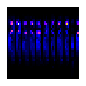

output_split/train/normal/murmur__201101180902.png


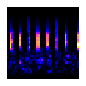

output_split/train/normal/Aunlabelledtest__201106111419.png


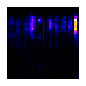

output_split/train/normal/normal__201102081152.png


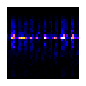

output_split/train/normal/normal__201103140135.png


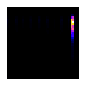

output_split/train/normal/Aunlabelledtest__201101220549.png


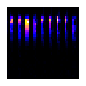

output_split/train/normal/Aunlabelledtest__2011040239.png


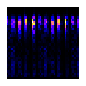

output_split/train/artifact/artifact__201105280851.png


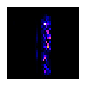

output_split/train/murmur/murmur__201108222256.png


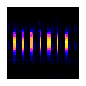

output_split/train/murmur/murmur__201104021355.png


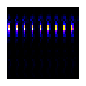

output_split/train/artifact/Aunlabelledtest__201106100606.png


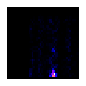

output_split/train/normal/Aunlabelledtest__201101110659.png


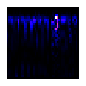

output_split/train/murmur/murmur__201108222223.png


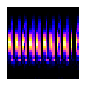

output_split/train/normal/murmur__201102051443.png


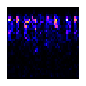

output_split/train/murmur/murmur__201101051114.png


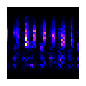

output_split/train/artifact/artifact__201106171003.png


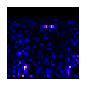

output_split/train/artifact/artifact__201106101955.png


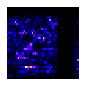

output_split/train/artifact/Aunlabelledtest__201106040930.png


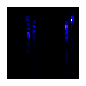

output_split/train/normal/normal__201105021654.png


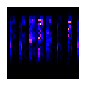

output_split/train/artifact/artifact__201106021541.png


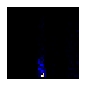

output_split/train/murmur/murmur__201108222248.png


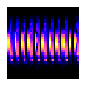

output_split/train/artifact/artifact__201106010559.png


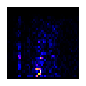

output_split/train/murmur/murmur__201108222221.png


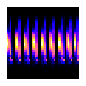

output_split/train/normal/extrahls__201103170134.png


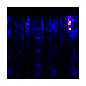

output_split/train/artifact/artifact__201106070949.png


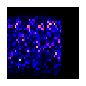

output_split/train/artifact/artifact__201105051017.png


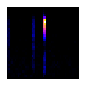

output_split/train/normal/extrahls__201101091153.png


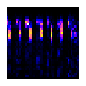

output_split/train/normal/normal__201108011118.png


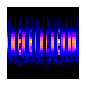

output_split/train/normal/normal__201103140132.png


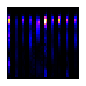

output_split/train/normal/normal__201103151912.png


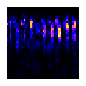

output_split/train/normal/normal__201105021804.png


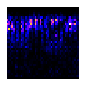

output_split/train/normal/Aunlabelledtest__201103140236.png


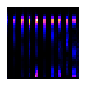

output_split/train/normal/normal__201104141251.png


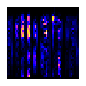

output_split/train/artifact/artifact__201106030612.png


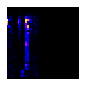

output_split/train/murmur/normal__201103101140.png


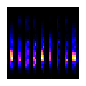

output_split/train/normal/extrahls__201102070251.png


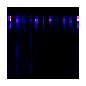

output_split/train/artifact/Aunlabelledtest__201106171155.png


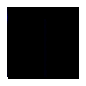

output_split/train/murmur/murmur__201101051108.png


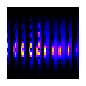

output_split/train/normal/extrahls__201104270459.png


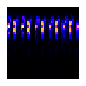

output_split/train/murmur/Aunlabelledtest__201108222254.png


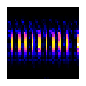

output_split/train/murmur/normal__201103221214.png


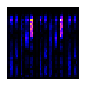

output_split/train/murmur/murmur__201108222235.png


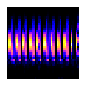

output_split/train/murmur/Aunlabelledtest__201108222247.png


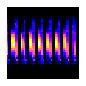

output_split/train/murmur/murmur__201108222237.png


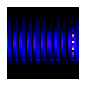

output_split/train/normal/extrahls__201104270458.png


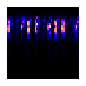

output_split/train/murmur/murmur__201108222246.png


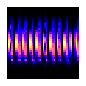

output_split/train/artifact/artifact__201106061233.png


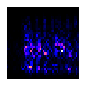

output_split/train/murmur/murmur__201108222258.png


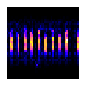

output_split/train/normal/normal__201102081321.png


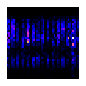

output_split/train/artifact/artifact__201106131834.png


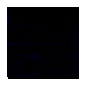

output_split/train/normal/extrahls__201102071835.png


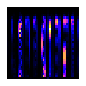

output_split/train/artifact/Aunlabelledtest__201012172010.png


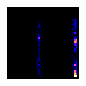

output_split/train/artifact/artifact__201106041452.png


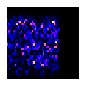

output_split/train/artifact/Aunlabelledtest__201106030607.png


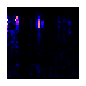

output_split/train/murmur/murmur__201108222253.png


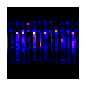

output_split/train/normal/normal__201106221418.png


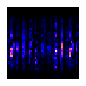

output_split/train/murmur/Aunlabelledtest__201108222241.png


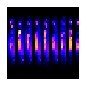

output_split/train/artifact/artifact__201105190800.png


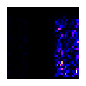

output_split/train/normal/Aunlabelledtest__201108011113.png


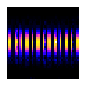

output_split/train/artifact/Aunlabelledtest__201106061104.png


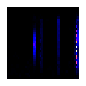

output_split/train/artifact/artifact__201106111119.png


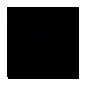

output_split/train/artifact/artifact__201106131835.png


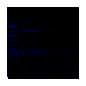

output_split/train/artifact/Aunlabelledtest__201106120928.png


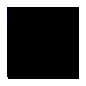

output_split/train/normal/Aunlabelledtest__201102081045.png


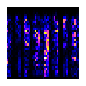

output_split/train/normal/extrahls__201101152255.png


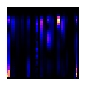

output_split/train/murmur/murmur__201108222243.png


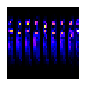

output_split/train/normal/normal__201106221450.png


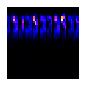

output_split/train/normal/Aunlabelledtest__20110501548.png


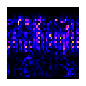

output_split/train/artifact/artifact__201106220340.png


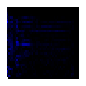

output_split/train/artifact/artifact__201106040722.png


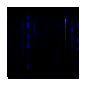

output_split/train/normal/normal__201104122156.png


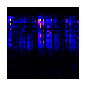

output_split/train/murmur/normal__201106151236.png


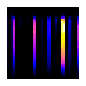

output_split/train/normal/murmur__201103291548.png


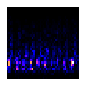

output_split/train/artifact/artifact__201106031558.png


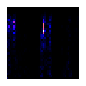

output_split/train/murmur/murmur__201108222251.png


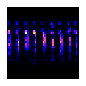

output_split/train/normal/normal__201102201230.png


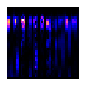

output_split/train/murmur/Aunlabelledtest__201108222234.png


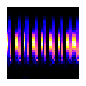

output_split/train/normal/extrahls__201102241217.png


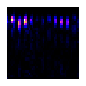

output_split/train/normal/Aunlabelledtest__201101152256.png


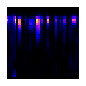

output_split/train/murmur/murmur__201108222226.png


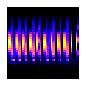

output_split/train/artifact/artifact__201106070537.png


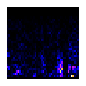

output_split/train/normal/Aunlabelledtest__201106211725.png


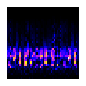

In [50]:
save_dataset(ds_samples_train, output_path / 'train')

output_split/valid/murmur/murmur__201108222255.png


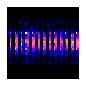

output_split/valid/normal/normal__201103090635.png


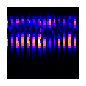

output_split/valid/normal/normal__201105011626.png


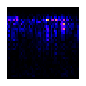

output_split/valid/artifact/artifact__201105041959.png


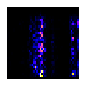

output_split/valid/normal/extrahls__201101160808.png


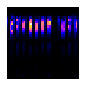

output_split/valid/artifact/Aunlabelledtest__201106191034.png


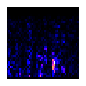

output_split/valid/murmur/murmur__201108222245.png


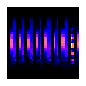

output_split/valid/artifact/artifact__201106121242.png


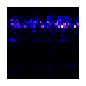

output_split/valid/normal/Aunlabelledtest__201105011546.png


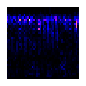

output_split/valid/artifact/Aunlabelledtest__201106061215.png


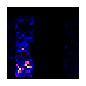

output_split/valid/murmur/Aunlabelledtest__201108222257.png


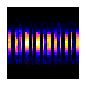

output_split/valid/normal/Aunlabelledtest__201103170122.png


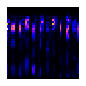

output_split/valid/murmur/murmur__201102052338.png


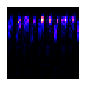

output_split/valid/artifact/artifact__201106161219.png


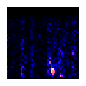

output_split/valid/artifact/artifact__201012172012.png


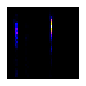

output_split/valid/normal/extrahls__201101161027.png


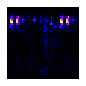

output_split/valid/murmur/murmur__201104241315.png


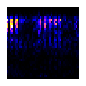

output_split/valid/normal/extrahls__201101241433.png


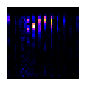

output_split/valid/murmur/murmur__201108222236.png


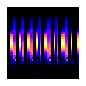

output_split/valid/artifact/artifact__201105061143.png


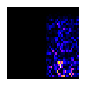

output_split/valid/normal/extrahls__201101241423.png


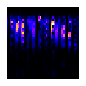

output_split/valid/artifact/artifact__201106161016.png


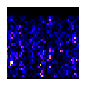

output_split/valid/normal/normal__201103170121.png


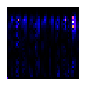

output_split/valid/normal/Aunlabelledtest__201101241434.png


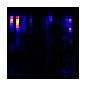

output_split/valid/murmur/Aunlabelledtest__201103200518.png


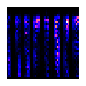

output_split/valid/artifact/artifact__201106121445.png


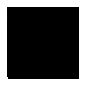

output_split/valid/normal/Aunlabelledtest__201103201314.png


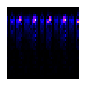

output_split/valid/murmur/Aunlabelledtest__201101061552.png


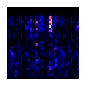

output_split/valid/normal/extrahls__201103200218.png


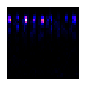

output_split/valid/murmur/murmur__201108222238.png


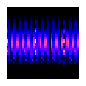

output_split/valid/murmur/extrahls__201101070953.png


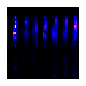

output_split/valid/murmur/murmur__201108222252.png


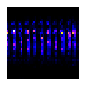

output_split/valid/artifact/artifact__201106190520.png


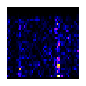

output_split/valid/normal/murmur__201104291843.png


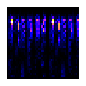

output_split/valid/murmur/murmur__201108222242.png


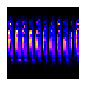

output_split/valid/artifact/artifact__201105060108.png


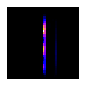

output_split/valid/normal/normal__201101151127.png


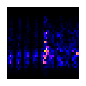

output_split/valid/normal/normal__201105151450.png


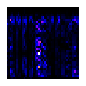

output_split/valid/artifact/Aunlabelledtest__201106150614.png


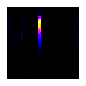

output_split/valid/artifact/artifact__201106110909.png


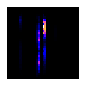

output_split/valid/murmur/Aunlabelledtest__201108011116.png


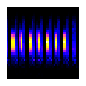

output_split/valid/normal/extrahls__201103182227.png


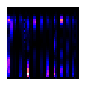

output_split/valid/murmur/normal__201106141148.png


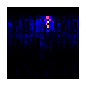

output_split/valid/artifact/artifact__201106040947.png


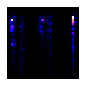

In [51]:
save_dataset(ds_samples_test, output_path / 'valid')

## Training on images

In [0]:
PATH = "/content/output_split/"

In [53]:
ls -lah $PATH

total 20K
drwxr-xr-x 4 root root 4.0K Dec 27 01:07 ./
drwxr-xr-x 1 root root 4.0K Dec 27 01:07 ../
drwxr-xr-x 5 root root 4.0K Dec 27 01:07 train/
drwxr-xr-x 5 root root 4.0K Dec 27 01:07 valid/


In [54]:
sz=224
arch=resnet34

tfms = tfms_from_model(arch, sz)

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4) # w razie czego 2 lub 4
learn = ConvLearner.pretrained(arch, data, precompute=False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 16.8MB/s]
/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [55]:
lrf = learn.lr_find()

 61%|██████    | 20/33 [00:00<00:02,  4.82it/s, loss=6.6] 


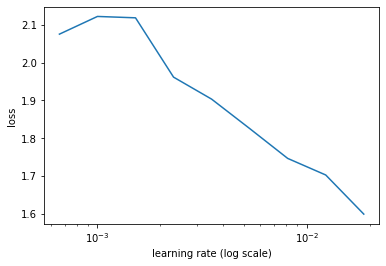

In [56]:
learn.sched.plot()

In [57]:
learn.metrics = []
learn.fit(0.001, 3)

epoch      trn_loss   val_loss   
    0      1.215163   0.512229  
    1      1.061121   0.428221  
    2      0.878161   0.462066  



[0.46206642280925403]

## Prediction & accuracy

In [0]:
log_preds = learn.predict()
y = data.val_y

In [0]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds);

In [60]:
accuracy_np(probs, y)

0.8409090909090909

## Confusion matrix

[[14  0  0]
 [ 1  9  4]
 [ 1  1 14]]


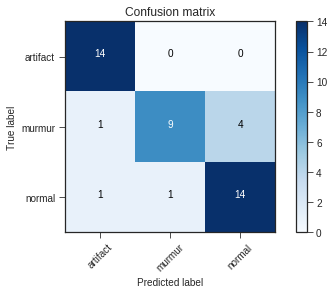

In [61]:
cm = confusion_matrix(y, preds)

mpl.style.use('seaborn-ticks')
plot_confusion_matrix(cm, data.classes)

# Training on audio samples

## The model: one dimensional convolutional neural network

In [0]:
class HeartbeatSoundsConvNet(nn.Module):

    def __init__(self, n_classes=3):
        super(HeartbeatSoundsConvNet, self).__init__()

        self.n_classes = n_classes

        self.b1 = nn.Sequential(*[
            # Conv1D(... kernel_regularizer = l2(0.025))
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=9),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=9, stride=4),
            nn.BatchNorm1d(num_features=4),
            nn.Dropout(p=0.2)
            # nn.Dropout(p=0.025)
        ])

        self.b2 = nn.Sequential(*[
            # Conv1D(... kernel_regularizer = l2(0.05))
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=9, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=9, stride=4, padding=4),
            nn.BatchNorm1d(num_features=4),
            nn.Dropout(p=0.2)
            # nn.Dropout(p=0.05)
        ])

        self.b3 = nn.Sequential(*[
            # Conv1D(... kernel_regularizer = l2(0.1))
            nn.Conv1d(in_channels=4, out_channels=8, kernel_size=9),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=9, stride=4, padding=4),
            nn.BatchNorm1d(num_features=8),
            nn.Dropout(p=0.1)
        ])

        self.b4 = nn.Sequential(*[
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=9),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=9, stride=4, padding=4),
            nn.BatchNorm1d(num_features=16),
            nn.Dropout(p=0.25),
        ])

        self.b5 = nn.Sequential(*[
            nn.Conv1d(in_channels=16, out_channels=64, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(num_features=64),
            nn.Dropout(p=0.5),    
        ])

        self.b6 = nn.Sequential(*[
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(num_features=32),
            nn.Dropout(p=0.75),
        ])

        # https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721/8
        # jdhao: Also you can use adaptive_avg_pool2d 115 to achieve global average pooling, just set the output size to (1, 1),                
        self.b7 = nn.AdaptiveAvgPool1d(output_size=1)  # GlobalAvgPool1D()

        self.rest_b7 = nn.Sequential(*[
            nn.Linear(in_features=32, out_features=n_classes),
            nn.LogSoftmax(dim=1)
        ])

    def forward(self, V):
        y = self.b1(V)
        y = self.b2(y)
        y = self.b3(y)
        y = self.b4(y)
        y = self.b5(y)
        y = self.b6(y)
        y = self.b7(y).squeeze()
        y = self.rest_b7(y)
        return y

In [63]:
model = HeartbeatSoundsConvNet(n_classes=5)
xt = x_train[:,np.newaxis, :]; print('xt:', xt.shape)
x = Variable(torch.from_numpy(xt[0:2]).float()); print('x:', x.shape)

if USE_CUDA:
  model = model.cuda()
  x = x.cuda()

y = model(x); print('y:', y.shape)

xt: (132, 1, 1551)
x: torch.Size([2, 1, 1551])
y: torch.Size([2, 5])


In [0]:
# print(model)

In [65]:
# https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/10
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


8313

This version of the net has about 8.000 parameters, and it could easily overfit our dataset of 125 time series if we let it run too long.

## Validation helpers

In [0]:
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='g', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper right')

def plot_ep_val_acc(ep_vals):
    plt.ylabel("valit acc")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    val_accs = [item[2] for item in list(ep_vals.values())]
    plt.plot(epochs, val_accs, c='r', label='valid acc')
    plt.legend(loc='upper right')

## Prediction helpers

In [0]:
def predict(x_data, n_classes, batch_size):
    # outputs class probabilities
    n_samples = x_data.shape[0]
    n_iters = n_samples//batch_size
    xt = x_data[:,np.newaxis, :]
    yt = np.zeros((n_samples, n_classes))
    for it in range(n_iters):
        idx = it*batch_size
        x_batch = Variable(torch.from_numpy(xt[idx:idx+batch_size]).float())

        if USE_CUDA:
          x_batch = x_batch.cuda()
        
        y_batch_pred = model(x_batch)
        y_batch_pred = np.exp(y_batch_pred.data.cpu().numpy())
        yt[idx:idx+batch_size] = y_batch_pred
    return yt

def predict_one(s):    
    s_test = s[np.newaxis, :1551]
    x_data = np.repeat(s_test, 2, axis=0)

    yt = predict(x_data, n_classes=3, batch_size=2)
        
    y_hat = yt[0,:]
    y_pred = np.argmax(y_hat)
    return y_hat, y_pred, CLASSES[y_pred]

## Starting training

In [0]:
class WavDataset(Dataset):
    def __init__(self, x, y, rotate_samples=True, multi=1): 
        self.x = x
        self.y = y
        self.rotate_samples = rotate_samples
        self.multi = multi

    @classmethod
    def rotate_sample(cls, x_sample):
        """
        Rotates the time series randomly in time
        """
        x_sample = x_sample.copy()    
        sz = np.random.randint(x_sample.shape[0])
        x_sample = np.roll(x_sample, sz, axis = 0)

        return x_sample

    def __getitem__(self, idx):
        idx = idx % len(self.x)
        if self.rotate_samples:
            x = self.__class__.rotate_sample(self.x[idx])
        else:
            x = self.x[idx]
        return A(x[np.newaxis,:], self.y[idx])
    def __len__(self): return len(self.x) * self.multi

In [0]:
bs=32
PATH='data'

trn_ds = WavDataset(x_train, y_train, rotate_samples=True, multi=50)
val_ds = WavDataset(x_test, y_test, rotate_samples=False, multi=1)
trn_dl = DataLoader(trn_ds, batch_size=bs, num_workers=1)
val_dl = DataLoader(val_ds, batch_size=bs, num_workers=1)
md = ModelData(PATH, trn_dl, val_dl)

In [0]:
model = HeartbeatSoundsConvNet(n_classes=len(CLASSES))
if USE_CUDA:
  model = model.cuda()

sm = SingleModel(model)
learn = Learner(md, sm, crit=F.nll_loss)
learn.unfreeze()

In [71]:
learn.lr_find()

 82%|████████▏ | 170/207 [00:02<00:00, 80.32it/s, loss=3.51]


In [0]:
%matplotlib inline

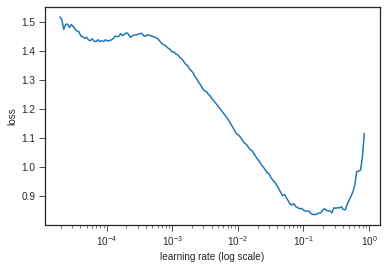

In [73]:
learn.sched.plot()

epoch      trn_loss   val_loss   
    0      0.581326   0.556152  
    1      0.440764   0.386337  
    2      0.383747   0.5135    
    3      0.342903   0.51522   



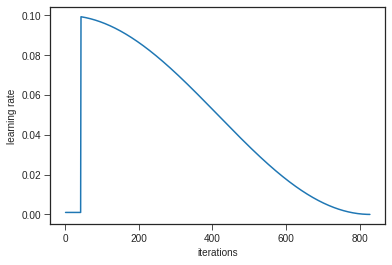

In [74]:
#learn.metrics = []
vals, ep_vals = learn.fit(0.1, 1, cycle_len=4, get_ep_vals=True)

learn.sched.plot_lr()

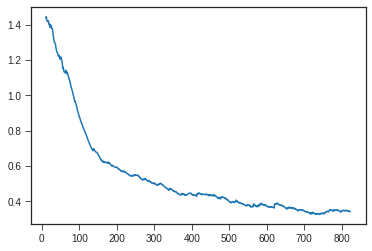

In [75]:
learn.sched.plot_loss()

In [76]:
print(ep_vals)

OrderedDict([(0, [0.581326, 0.556152]), (1, [0.440764, 0.386337]), (2, [0.383747, 0.5135]), (3, [0.342903, 0.51522])])


In [77]:
learn.lr_find()

 87%|████████▋ | 180/207 [00:02<00:00, 81.64it/s, loss=1.57]


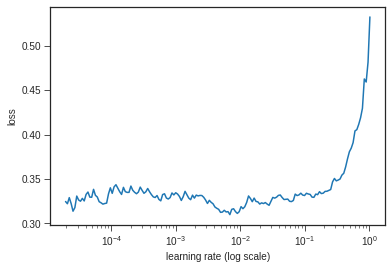

In [78]:
learn.sched.plot()

epoch      trn_loss   val_loss   
    0      0.337645   0.514472  
    1      0.31828    0.513394  
    2      0.343155   0.508472  
    3      0.340046   0.494829  



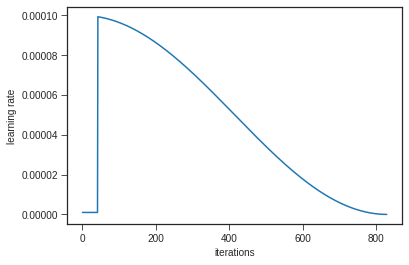

In [79]:
vals, ep_vals = learn.fit(0.0001, 1, cycle_len=4, get_ep_vals=True)

learn.sched.plot_lr()

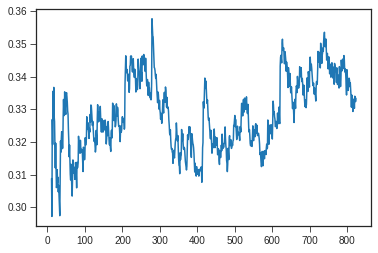

In [80]:
learn.sched.plot_loss()

In [81]:
print(ep_vals)

OrderedDict([(0, [0.337645, 0.514472]), (1, [0.31828, 0.513394]), (2, [0.343155, 0.508472]), (3, [0.340046, 0.494829])])


# Prediction on test split

In [0]:
y_hat = predict(x_test, n_classes=len(CLASSES), batch_size=2)
y_pred = np.argmax(y_hat, axis=1)

## Show predictions per class

artifact
normal
murmur


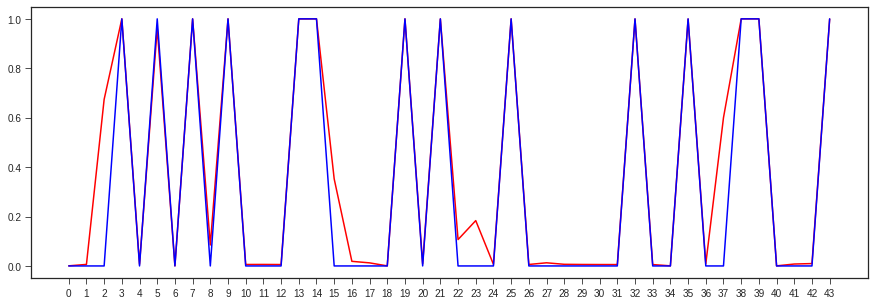

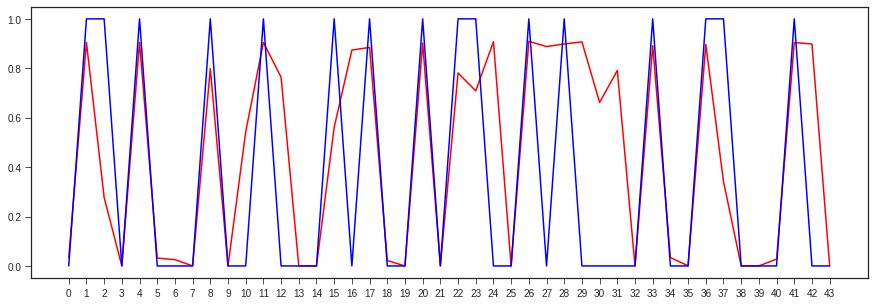

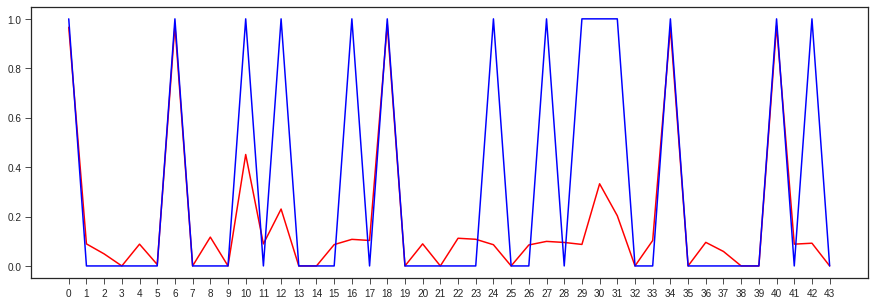

In [83]:
np.set_printoptions(precision=2, suppress=True)
num_samples = len(x_test)
for i in range(len(CLASSES)):
    print(CLASSES[i])
    plt.figure(figsize=(15,5))
    plt.plot(y_hat[:,i], c='r')
    plt.plot([y==i for y in y_test], c='b')
    plt.xticks(range(num_samples), range(num_samples))
    plt.show()

## Number of samples per class for dataset and train, test splits

In [84]:
y_classes = [s.y_class for s in ds_samples]
Counter(y_classes)

Counter({'artifact': 58, 'murmur': 53, 'normal': 65})

In [85]:
y_test_classes = [CLASSES[y] for y in y_test]
Counter(y_test_classes)

Counter({'artifact': 14, 'murmur': 14, 'normal': 16})

In [86]:
y_train_classes = [CLASSES[y] for y in y_train]
Counter(y_train_classes)

Counter({'artifact': 44, 'murmur': 39, 'normal': 49})

## Confusion matrix

[[14  0  0]
 [ 2 14  0]
 [ 0  9  5]]


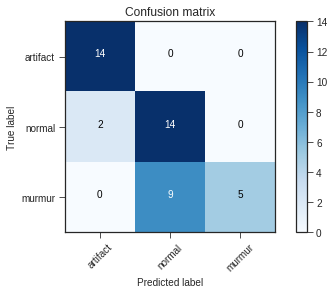

In [87]:
cm = confusion_matrix(y_test, y_pred)

mpl.style.use('seaborn-ticks')
plot_confusion_matrix(cm, CLASSES)

## Wrong predictions

1 File: data/heartbeat-sounds/heartbeat-sounds5/normal/normal__201105011626.wav, Pred: artifact, True: normal
2 File: data/heartbeat-sounds/heartbeat-sounds5/murmur/Aunlabelledtest__201108222257.wav, Pred: normal, True: murmur
3 File: data/heartbeat-sounds/heartbeat-sounds5/murmur/murmur__201102052338.wav, Pred: normal, True: murmur
4 File: data/heartbeat-sounds/heartbeat-sounds5/murmur/murmur__201104241315.wav, Pred: normal, True: murmur
5 File: data/heartbeat-sounds/heartbeat-sounds5/murmur/Aunlabelledtest__201103200518.wav, Pred: normal, True: murmur
6 File: data/heartbeat-sounds/heartbeat-sounds5/murmur/Aunlabelledtest__201101061552.wav, Pred: normal, True: murmur
7 File: data/heartbeat-sounds/heartbeat-sounds5/murmur/murmur__201108222238.wav, Pred: normal, True: murmur
8 File: data/heartbeat-sounds/heartbeat-sounds5/murmur/extrahls__201101070953.wav, Pred: normal, True: murmur
9 File: data/heartbeat-sounds/heartbeat-sounds5/murmur/murmur__201108222252.wav, Pred: normal, True: murm

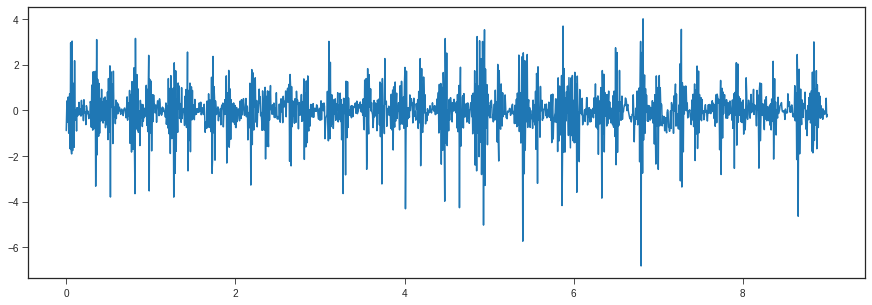

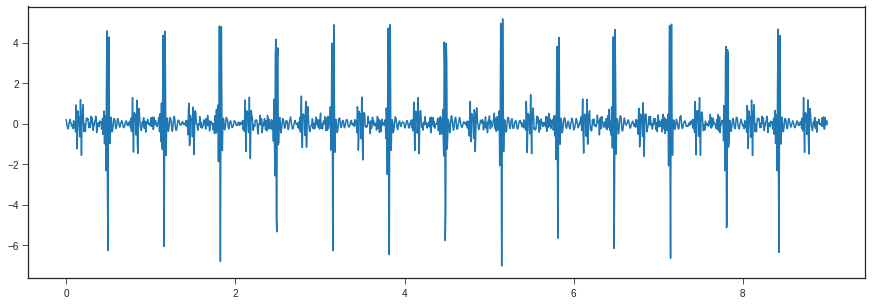

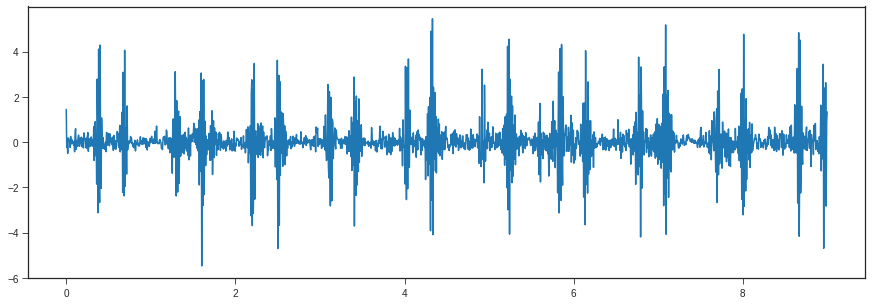

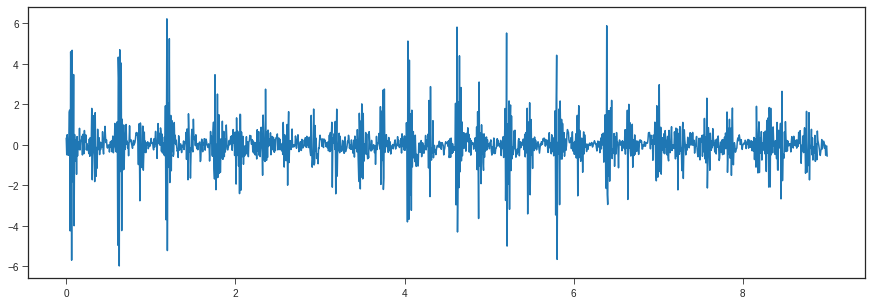

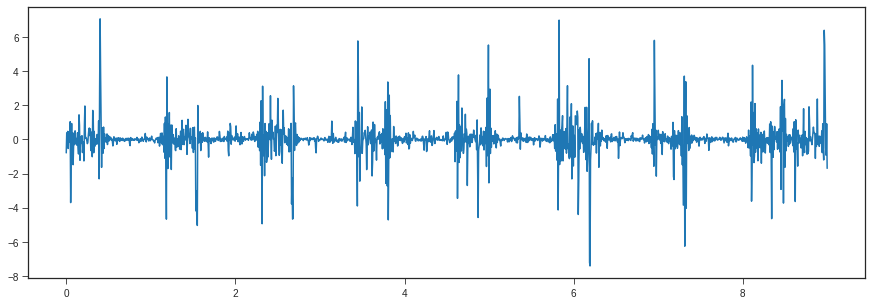

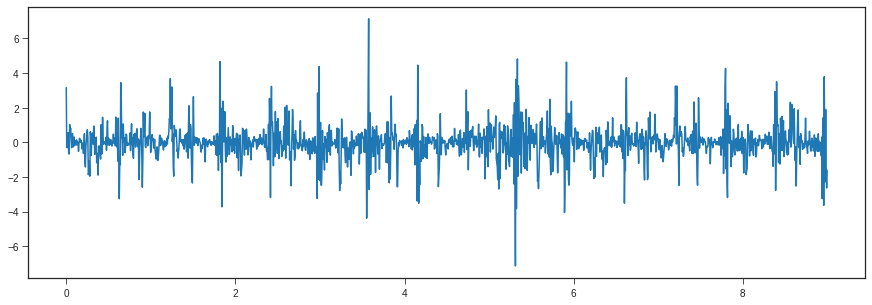

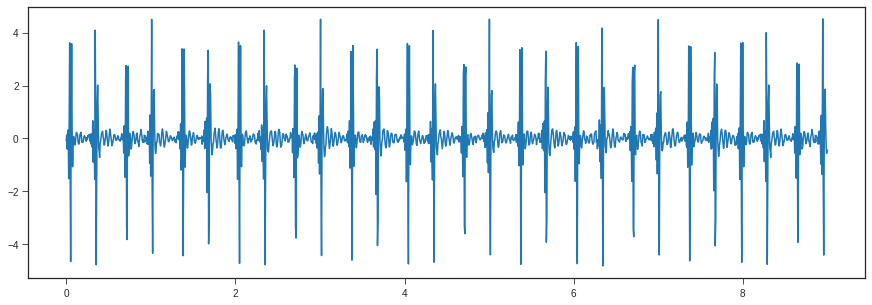

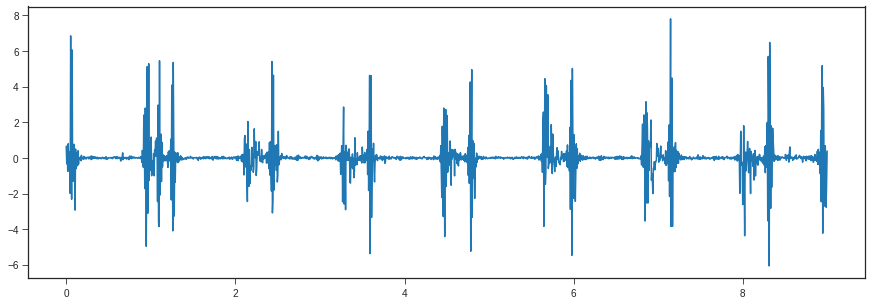

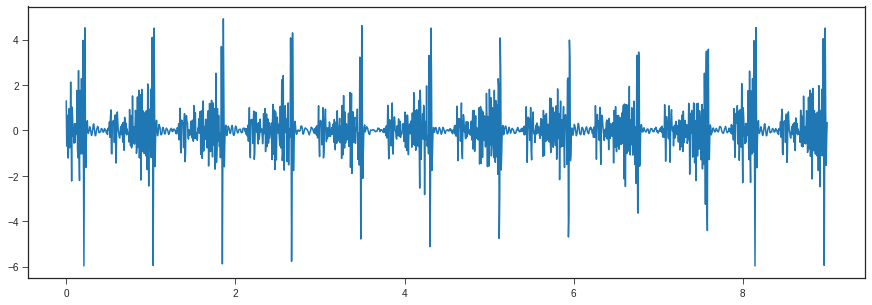

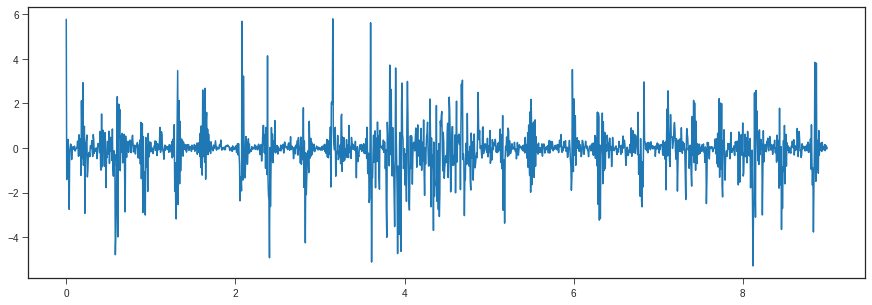

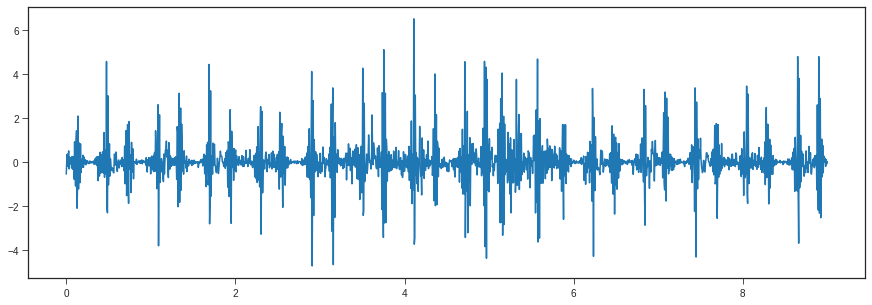

In [88]:
bad_count = 0
for i in range(len(y_test)):
    if y_pred[i] != y_test[i]:
        bad_count += 1
        ds_sample = ds_samples_test[i]
        print("{} File: {}, Pred: {}, True: {}".format(bad_count, ds_sample.fn_path, CLASSES[y_pred[i]], CLASSES[y_test[i]]))
        t2 = times_array(x_test[i], ds_sample.framerate_downsampled)
        plt.figure(figsize=(15,5))
        plt.plot(t2, x_test[i])
        plt.show()

Not too bad. If this dataset really comes from an iPhone app, it is truly impressive.

# Predictions from files

## Prediction on a file

In [0]:
# FNAME = 'data/heartbeat-sounds/set_a/normal__201101070538.wav'
# FNAME = 'data/custom_samples/heartbeat_2_wcz.wav'
# FNAME = 'data/custom_samples/Serce_kw_normalized.wav'
# FNAME = 'data/custom_samples/Aga_Serce_normalized.wav'
# FNAME = 'data/custom_samples/Z_Halasami.wav'
FNAME = 'data/heartbeat-sounds/custom_samples/Z_Halasami2.wav'
# FNAME = 'data/heartbeat-sounds/set_a/artifact__201012172012.wav'
# FNAME = 'data/heartbeat-sounds/set_a/artifact__201012172012.wav'
# FNAME = 'data/heartbeat-sounds/set_a/Aunlabelledtest__201101061552.wav'
# FNAME = 'data/heartbeat-sounds/set_a/normal__201102081321.wav'
# FNAME = 'data/Bunlabelledtest/Bunlabelledtest__101_1305030823364_F.wav'
# FNAME = 'data/Bunlabelledtest/Bunlabelledtest__163_1307104470471_D.wav'


In [90]:
ds_sample = dataset_sample_from_file(FNAME)
ds_sample = process_dataset_sample(ds_sample, EXPECTED_LENGTH, DOWNSAMPLING_FACTORS)
t2 = times_array(ds_sample.samples_downsampled, ds_sample.framerate_downsampled)
predict_one(ds_sample.samples_downsampled)

(array([0.81, 0.16, 0.03]), 0, 'artifact')

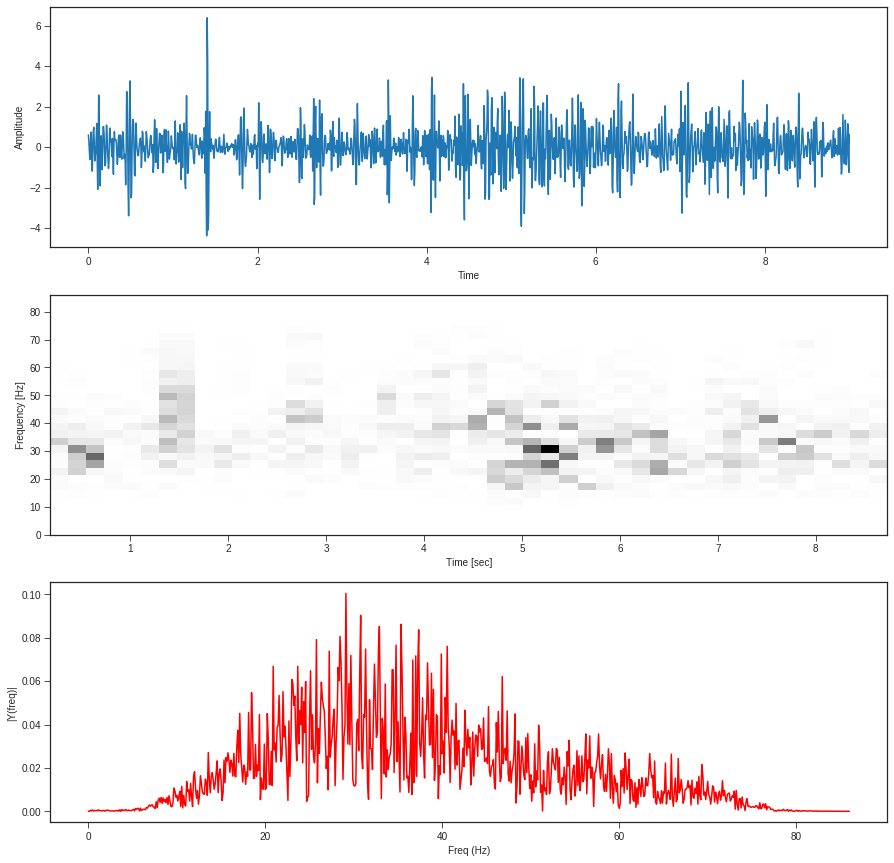

In [91]:
plotWaveformSpectrogramAndSpectrum(ds_sample.samples_downsampled, ds_sample.framerate_downsampled, t2)

## Prediction on a folder

In [0]:
# samples_path = Path('data/heartbeat-sounds/set_a')
samples_path = Path('data/heartbeat-sounds/custom_samples')
# samples_path = Path('data/custom_samples')
# samples_path = Path('data/Bunlabelledtest')

In [93]:
filenames = sorted(list(samples_path.iterdir())); filenames[:3]

[PosixPath('data/heartbeat-sounds/custom_samples/Aga_Serce_normalized.wav'),
 PosixPath('data/heartbeat-sounds/custom_samples/Serce_kw_normalized.wav'),
 PosixPath('data/heartbeat-sounds/custom_samples/Z_Halasami.wav')]

In [94]:
for fn_path in filenames:
    ds_sample = dataset_sample_from_file(fn_path)
    ds_sample = process_dataset_sample(ds_sample, EXPECTED_LENGTH, DOWNSAMPLING_FACTORS)
    yt, y_pred, a_class = predict_one(ds_sample.samples_downsampled)
    print(y_pred, a_class, fn_path.name)

1 normal Aga_Serce_normalized.wav
1 normal Serce_kw_normalized.wav
0 artifact Z_Halasami.wav
0 artifact Z_Halasami2.wav
1 normal heartbeat_2_wcz.wav
1 normal heartbeat_normalized_wcz.wav


/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


1 normal Aga_Serce_normalized.wav
1 normal Serce_kw_normalized.wav
0 artifact Z_Halasami.wav
0 artifact Z_Halasami2.wav
1 normal heartbeat_2_wcz.wav
1 normal heartbeat_normalized_wcz.wav


/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


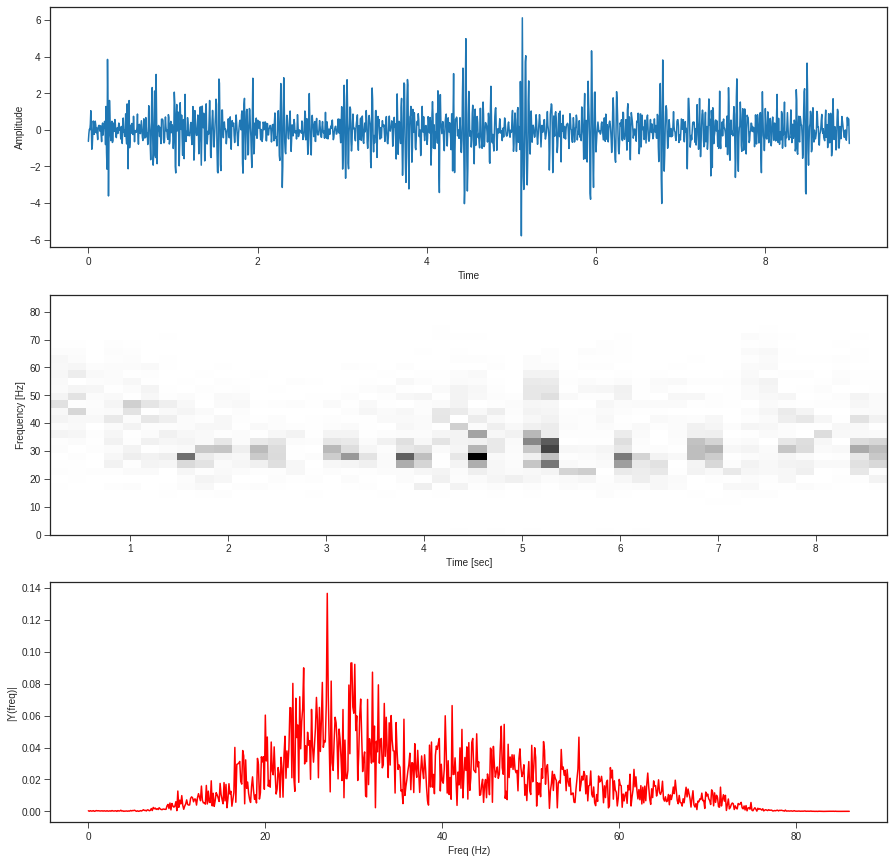

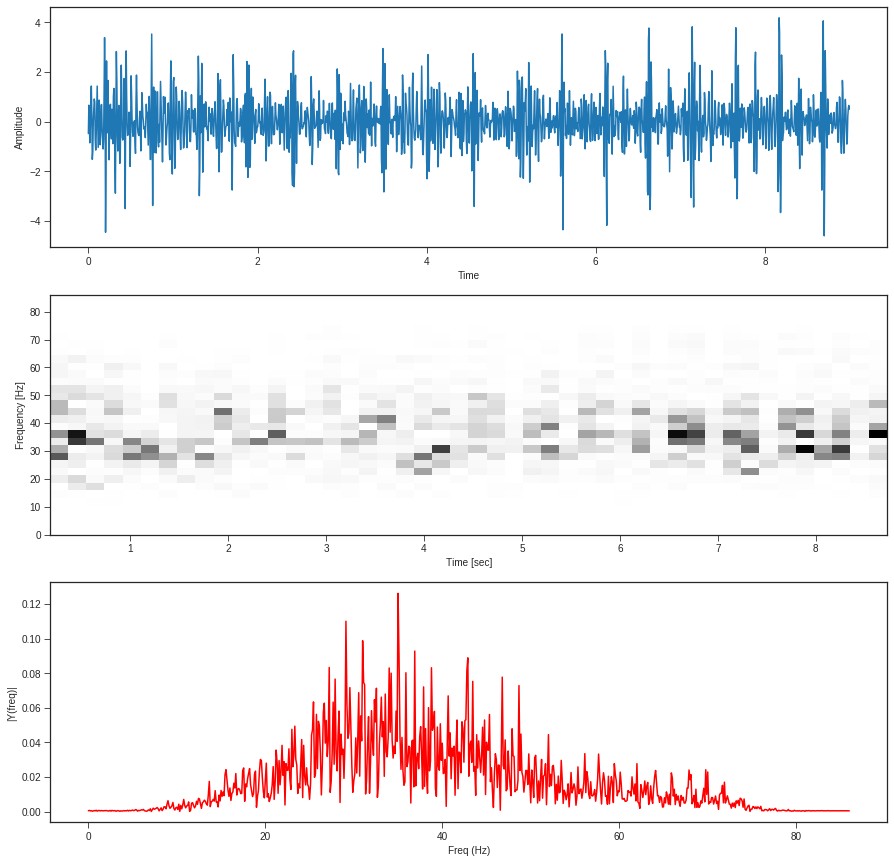

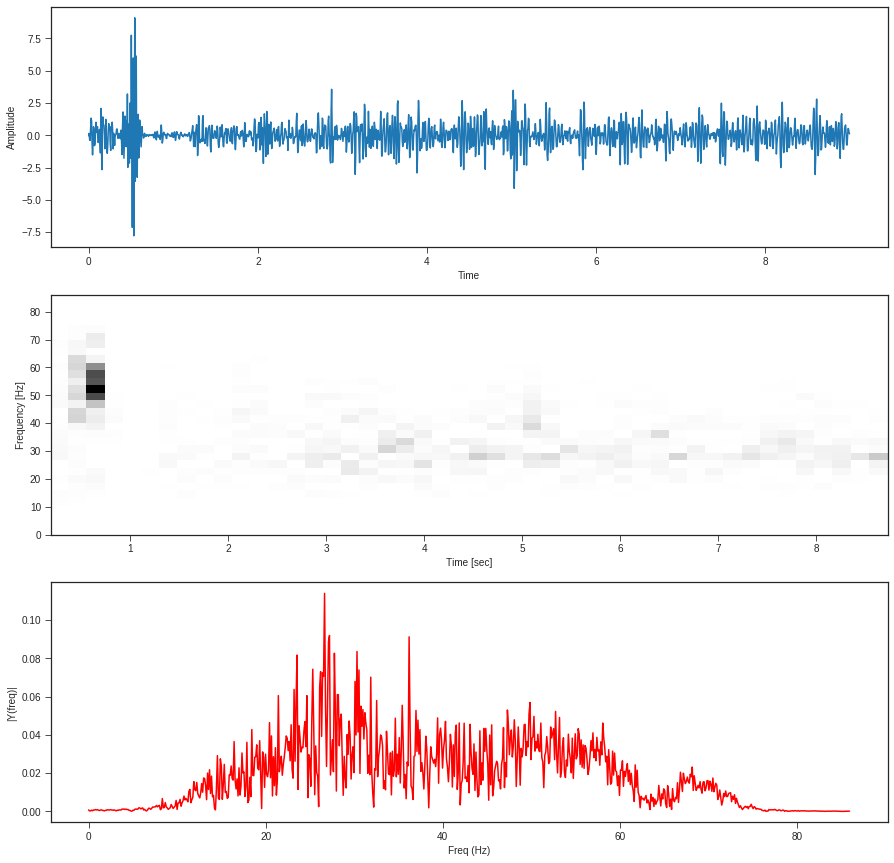

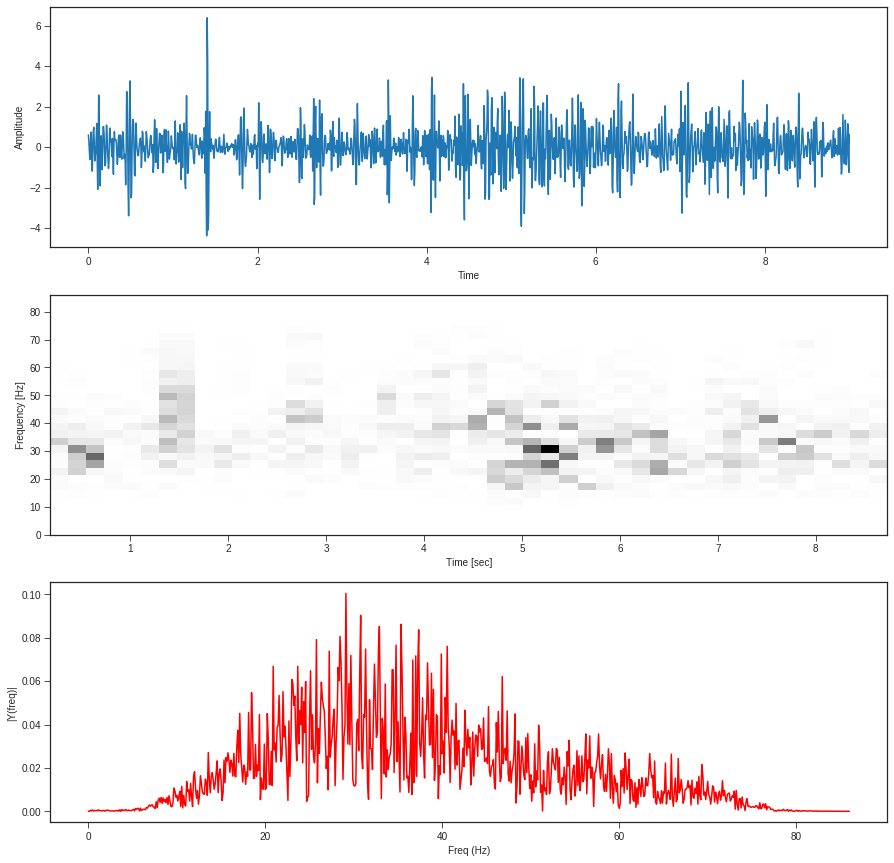

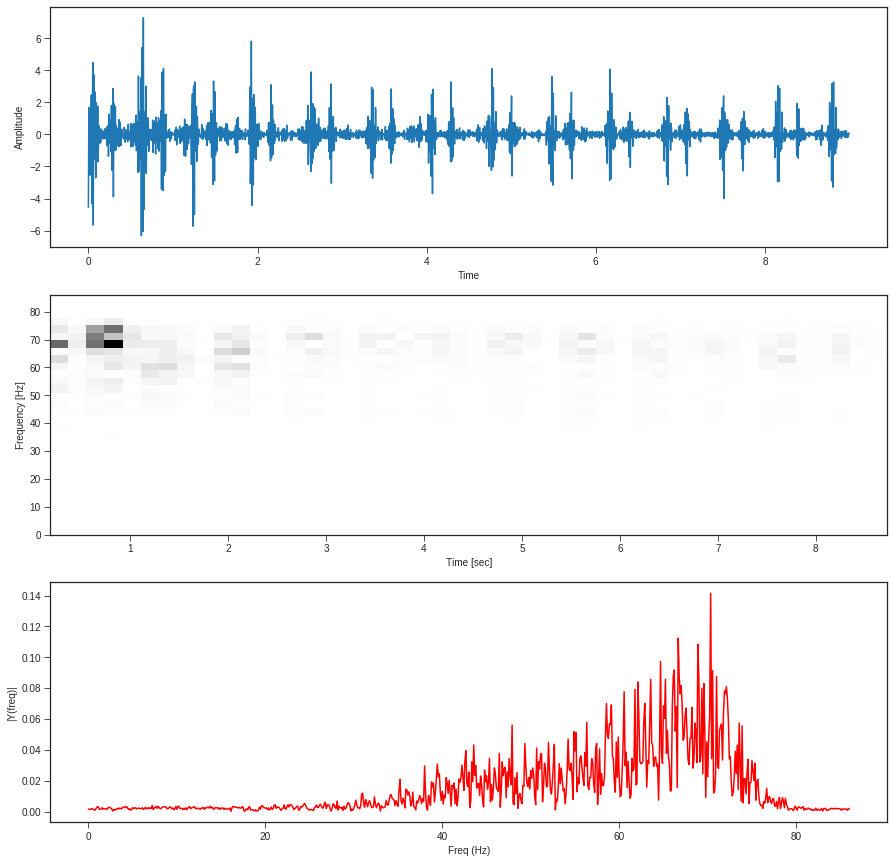

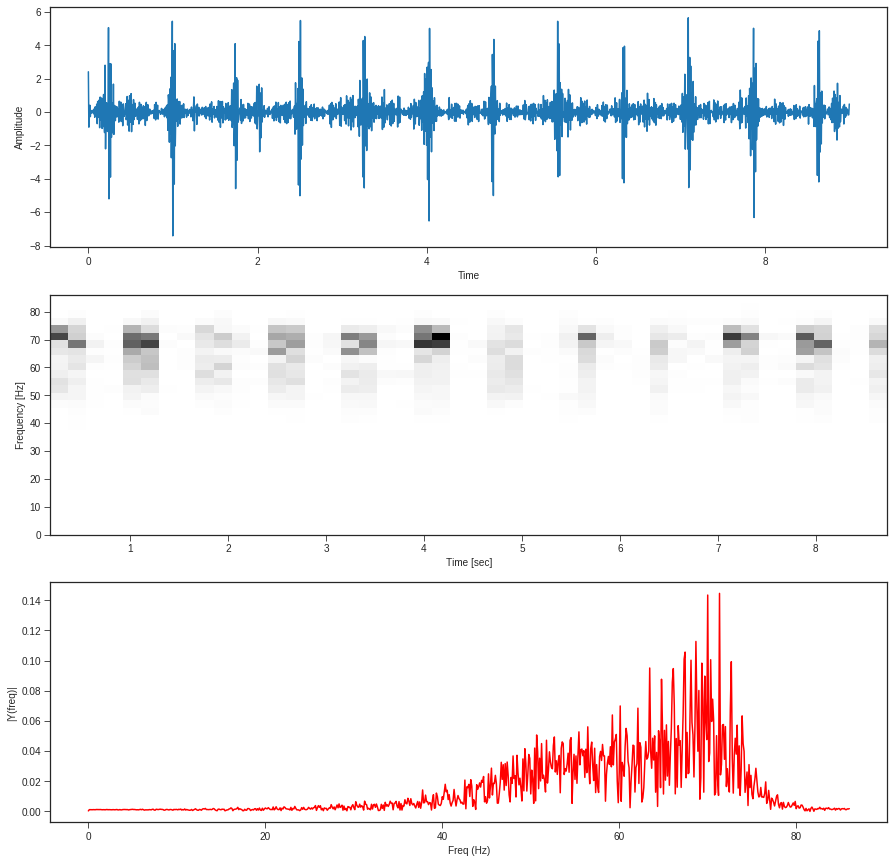

In [95]:
for fn_path in filenames:
    ds_sample = dataset_sample_from_file(fn_path)
    ds_sample = process_dataset_sample(ds_sample, EXPECTED_LENGTH, DOWNSAMPLING_FACTORS)
    t2 = times_array(ds_sample.samples_downsampled, ds_sample.framerate_downsampled)
    yt, y_pred, a_class = predict_one(ds_sample.samples_downsampled)
    
    print(y_pred, a_class, fn_path.name)
    plotWaveformSpectrogramAndSpectrum(ds_sample.samples_downsampled, ds_sample.framerate_downsampled, t2)